## TM-TV exercise

0. import resources

In [18]:
import nltk 
import spacy

from collections import defaultdict
#import csv
import ast
import os
import warnings

import matplotlib.pyplot as plt
import pandas as pd

import pyLDAvis
import pyLDAvis.gensim_models
from gensim.models import CoherenceModel, LdaModel
from gensim import corpora, similarities, utils
from gensim.models.phrases import Phrases, Phraser, ENGLISH_CONNECTOR_WORDS

from sklearn.datasets import fetch_20newsgroups

import matplotlib.colors as mcolors
from wordcloud import WordCloud

warnings.filterwarnings('ignore') # setting ignore as a parameter

nlp = spacy.load("en_core_web_sm")
stopwords = nltk.corpus.stopwords.words('english')

print("Libraries imported successfully!")

Libraries imported successfully!


1. Create the corpus -> dictionary with frequency of words for each document and dictionary with tags associated (for further analysis)

1.1 Choose documents

1.2 Pre processing

1.3 Create the dictionary with frequencies 

In [3]:

newsgroups_train = fetch_20newsgroups(subset='train', shuffle = True, remove=('headers', 'footers', 'quotes'))
newsgroups_test = fetch_20newsgroups(subset='test', shuffle = True, remove=('headers', 'footers', 'quotes'))

texts = newsgroups_train.data[:5000]
targets = newsgroups_train.target[:5000]
texts_test = newsgroups_test.data[:100]
targets_test = newsgroups_test.target[:100]
print(list(newsgroups_train.target_names))
# Lets look at some sample news
newsgroups_train.data[:2]

print(len(newsgroups_train.data))

['alt.atheism', 'comp.graphics', 'comp.os.ms-windows.misc', 'comp.sys.ibm.pc.hardware', 'comp.sys.mac.hardware', 'comp.windows.x', 'misc.forsale', 'rec.autos', 'rec.motorcycles', 'rec.sport.baseball', 'rec.sport.hockey', 'sci.crypt', 'sci.electronics', 'sci.med', 'sci.space', 'soc.religion.christian', 'talk.politics.guns', 'talk.politics.mideast', 'talk.politics.misc', 'talk.religion.misc']
11314


In [77]:
path = f'resources/inshort_news_data-5.csv'
path_corpus = f'resources/corpus.txt'
path_target = f'resources/target.txt'
features = []

def load_corpus():
    if not os.path.exists(path_corpus):
        texts = []
        targets = []

        with open(path, 'r', encoding='utf-8') as f:
            reader = csv.reader(f)
            i = 0
            for article in reader:
                if i == 0: 
                    features = article.insert(0, "id")
                    i += 1
                else:
                    text = article[2].replace("\n", " ")
                    texts.append(text)
                    target = article[3]
                    targets.append(target)
                    i += 1
    
        with open (path_corpus, 'w', encoding='utf-8') as f:
            for text in texts:
                f.write('"'+text+'"'+"\n")

        with open (path_target, 'w', encoding='utf-8') as f:
            for target in targets:
                f.write(target+"\n")
    else: 
        
        texts = []
        with open(path_corpus, 'r', encoding='utf-8') as f:
            texts = f.readlines()
            texts = [text.replace('"', '') for text in texts]

        targets = []
        with open(path_target, 'r', encoding='utf-8') as f:
            targets = f.readlines()
    
    return texts, targets

texts, targets = load_corpus()

n_topics = len(list(set(targets)))

print("Number of topics: ", n_topics)

print("Distribution topics: ", dict(pd.Series(targets).value_counts()))

Number of topics:  7
Distribution topics:  {'technology\n': 50, 'sports\n': 50, 'world\n': 50, 'politics\n': 50, 'entertainment\n': 50, 'automobile\n': 50, 'science\n': 50}


2. Create the model 

2.1 Pre processing

2.2 Building Dictionary & Corpus for Topic Model

2.3 Building LDA Topic Model

In [4]:
# Tokenization

def texts_to_tokens(texts: list): 
     texts_token = []
     texts = [text.replace("\n", " ") for text in texts]
     docs = list(nlp.pipe(texts, disable=['ner']))
     for doc in docs:
          #text.replace("\n", " ")
          #text_tokens = nlp(text)
          text_tokens = [token.lemma_ for token in doc if len(token.text) > 2 and not token.is_stop and \
                not token.is_punct and token.is_alpha and token.pos_ in ['NOUN', 'VERB', 'ADJ', 'ADV']]
          text_tokens = list(set(text_tokens))
          texts_token.append(text_tokens)

     return texts_token

def add_bigrams(texts_token: list):
     bigram = Phrases(texts_token, min_count=5, threshold=100, connector_words=ENGLISH_CONNECTOR_WORDS)
     for idx in range(len(texts_token)):
          for token in bigram[texts_token[idx]]:
               if '_' in token and token not in texts_token[idx]:
                    texts_token[idx].append(token)

     return texts_token

texts_token = texts_to_tokens(texts)
print("Tokenization done!")
texts_token = add_bigrams(texts_token)
print("added bigrams!")

Tokenization done!
added bigrams!


In [5]:
'''
Preview 'processed_docs'
'''
print(texts_token[:2])

[['body', 'history', 'funky', 'tellme', 'mail', 'info', 'know', 'see', 'production', 'wonder', 'spec', 'look', 'late', 'separate', 'bumper', 'car', 'small', 'addition', 'model', 'door', 'rest', 'engine', 'early', 'sport', 'enlighten', 'day', 'year', 'call'], ['experience', 'sink', 'knowledge', 'fair', 'card', 'rate', 'brief', 'brave', 'hour', 'procedure', 'add', 'soul', 'floppy', 'request', 'base', 'poll', 'adapter', 'network', 'heat', 'upgrade', 'answer', 'clock', 'message', 'send', 'number', 'summarize', 'functionality', 'thank', 'usage', 'day', 'speed', 'oscillator', 'detail', 'attain', 'disk', 'especially', 'share']]


In [6]:
dictionary = corpora.Dictionary(texts_token)

dictionary.filter_extremes(no_below=15, no_above=0.1, keep_n= 100000)

In [7]:
corpus = [dictionary.doc2bow(text) for text in texts_token]

lda_model = LdaModel(corpus=corpus, num_topics=8, id2word=dictionary, random_state=100)
lda_model.show_topics()

[(0,
  '0.005*"number" + 0.004*"sure" + 0.004*"lot" + 0.004*"real" + 0.004*"read" + 0.004*"call" + 0.004*"leave" + 0.004*"long" + 0.003*"little" + 0.003*"ask"'),
 (1,
  '0.005*"program" + 0.005*"information" + 0.004*"read" + 0.004*"set" + 0.004*"call" + 0.004*"help" + 0.004*"mean" + 0.004*"source" + 0.003*"believe" + 0.003*"real"'),
 (2,
  '0.004*"day" + 0.004*"believe" + 0.004*"let" + 0.004*"system" + 0.003*"post" + 0.003*"question" + 0.003*"state" + 0.003*"long" + 0.003*"law" + 0.003*"support"'),
 (3,
  '0.006*"hear" + 0.005*"write" + 0.004*"read" + 0.004*"run" + 0.004*"change" + 0.004*"system" + 0.004*"help" + 0.004*"program" + 0.004*"file" + 0.004*"software"'),
 (4,
  '0.007*"low" + 0.006*"buy" + 0.005*"power" + 0.005*"probably" + 0.005*"sell" + 0.004*"likely" + 0.004*"system" + 0.004*"interested" + 0.004*"usually" + 0.004*"well"'),
 (5,
  '0.007*"mail" + 0.006*"like" + 0.006*"question" + 0.006*"drive" + 0.005*"help" + 0.005*"post" + 0.004*"game" + 0.004*"line" + 0.004*"well" + 0.0

3. Visualizations of the model 

In [8]:
pyLDAvis.enable_notebook()
pyLDAvis.gensim_models.prepare(lda_model, corpus, dictionary)

PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
7     -0.017842  0.006096       1        1  21.253316
2     -0.029989  0.009248       2        1  19.296368
0     -0.003876  0.000368       3        1  15.406799
5      0.001023 -0.032415       4        1  13.349101
3     -0.021719  0.003790       5        1  12.058271
1     -0.066241  0.025146       6        1   7.321593
6      0.045416 -0.069210       7        1   7.081452
4      0.093229  0.056978       8        1   4.233101, topic_info=         Term        Freq       Total Category  logprob  loglift
203       buy  264.000000  264.000000  Default  30.0000  30.0000
335       low  223.000000  223.000000  Default  29.0000  29.0000
11       mail  277.000000  277.000000  Default  28.0000  28.0000
233      sell  225.000000  225.000000  Default  27.0000  27.0000
353     power  255.000000  255.000000  Default  26.0000  26.0000
..        ...         ...         ...      ...      ...      ...
492      long   22.080403  419.361316   Topic8  -5.6672   0.2182
507  possible   20.022387  260.169309   Topic8  -5.7650   0.5978
110   suppose   18.541385  169.096299   Topic8  -5.8419   0.9518
24       base   19.613237  280.838808   Topic8  -5.7857   0.5007
687       lot   19.798598  362.159698   Topic8  -5.7763   0.2558

[600 rows x 6 columns], token_table=      Topic      Freq   Term
term                        
170       2  0.086170   SCSI
170       4  0.517021   SCSI
170       5  0.086170   SCSI
170       6  0.172340   SCSI
170       7  0.129255   SCSI
...     ...       ...    ...
2191      2  0.163476  yield
2191      3  0.054492  yield
2191      4  0.054492  yield
2191      5  0.599410  yield
2191      7  0.054492  yield

[2945 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[8, 3, 1, 6, 4, 2, 7, 5])

In [9]:
for i in range(len(texts)):
    print(lda_model[corpus][i])

[(4, 0.24552336), (6, 0.7203076)]
[(2, 0.0941451), (4, 0.33126718), (5, 0.55616385)]
[(5, 0.63381857), (6, 0.22860272), (7, 0.12101897)]
[(0, 0.017893), (1, 0.017883377), (2, 0.017880073), (3, 0.01789114), (4, 0.017873878), (5, 0.8748333), (6, 0.017873125), (7, 0.017872129)]
[(7, 0.9538662)]
[(0, 0.9649337)]
[(5, 0.9484194)]
[(1, 0.8581347), (5, 0.12040324)]
[(0, 0.015638238), (1, 0.015659023), (2, 0.015646208), (3, 0.60523117), (4, 0.015646378), (5, 0.30088797), (6, 0.015642257), (7, 0.0156487)]
[(3, 0.8170438), (4, 0.15790012)]
[(4, 0.43677354), (5, 0.5214882)]
[(0, 0.044120755), (1, 0.57844776), (7, 0.369888)]
[(0, 0.125), (1, 0.125), (2, 0.125), (3, 0.125), (4, 0.125), (5, 0.125), (6, 0.125), (7, 0.125)]
[(1, 0.31165582), (2, 0.24830052), (3, 0.38811678), (4, 0.047200207)]
[(6, 0.9686981)]
[(7, 0.9601545)]
[(2, 0.48988357), (3, 0.49478117)]
[(0, 0.22190352), (3, 0.15040715), (5, 0.07065682), (6, 0.25536907), (7, 0.29474404)]
[(2, 0.23719677), (4, 0.40935338), (5, 0.32936627)]
[(3, 

4. Evaluation of the model

In [10]:
# Compute Perplexity
# a measure of how good the model is. lower the better.
print('\nPerplexity: ', lda_model.log_perplexity(corpus))  # a measure of how good the model is. lower the better.

# Compute Coherence Score
coherence_model_lda = CoherenceModel(model=lda_model, corpus=corpus, texts=texts_token, dictionary=dictionary,
                                     coherence='u_mass', processes=3)
coherence_lda = coherence_model_lda.get_coherence()
print('\nCoherence Score: ', coherence_lda)


Perplexity:  -7.683619615698059

Coherence Score:  -1.9186458826998831


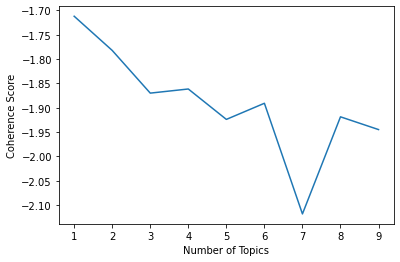

In [11]:
topics = []
score = []
for i in range(1,10,1):
   lda_model_eval = LdaModel(corpus=corpus, num_topics=i, id2word=dictionary, random_state=100)
   cm = CoherenceModel(model=lda_model_eval, corpus=corpus, dictionary=dictionary, coherence='u_mass')
   topics.append(i)
   score.append(cm.get_coherence())
_=plt.plot(topics, score)
_=plt.xlabel('Number of Topics')
_=plt.ylabel('Coherence Score')
plt.show()

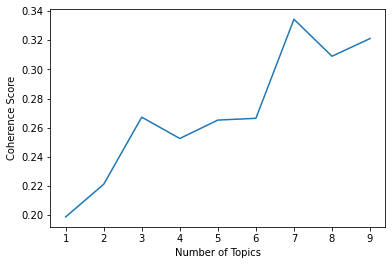

In [83]:
topics = []
score = []
for i in range(1,10,1):
   lda_model_eval = LdaModel(corpus=corpus, id2word=dictionary,num_topics=i, random_state=100)
   cm = CoherenceModel(model=lda_model_eval, texts = texts_token, corpus=corpus, dictionary=dictionary, coherence='c_v')
   topics.append(i)
   score.append(cm.get_coherence())
_=plt.plot(topics, score)
_=plt.xlabel('Number of Topics')
_=plt.ylabel('Coherence Score')
plt.show()

4. Analysis of the topics using target

In [12]:
topics = [sorted(lda_model[corpus][text])[0][0] for text in range(len(texts))]

topics_df = pd.DataFrame(topics, columns=['topic'])
topics_df['topic'].value_counts().sort_index()

0    2790
1     467
2     493
3     425
4     191
5     363
6     119
7     152
Name: topic, dtype: int64

In [13]:
y_topic = topics_df['topic'].values
lda_topics = lda_model.show_topics(formatted=False)

lda_topics = [[word for word, prob in topic] for topicid, topic in lda_topics]

for text in range(len(texts)): 
    print("Text: ", text)
    print("Result model: ", lda_topics[y_topic[text]])
    print("Real tags: ", targets[text])

Text:  0
Result model:  ['low', 'buy', 'power', 'probably', 'sell', 'likely', 'system', 'interested', 'usually', 'well']
Real tags:  7
Text:  1
Result model:  ['day', 'believe', 'let', 'system', 'post', 'question', 'state', 'long', 'law', 'support']
Real tags:  4
Text:  2
Result model:  ['day', 'believe', 'let', 'system', 'post', 'question', 'state', 'long', 'law', 'support']
Real tags:  4
Text:  3
Result model:  ['number', 'sure', 'lot', 'real', 'read', 'call', 'leave', 'long', 'little', 'ask']
Real tags:  1
Text:  4
Result model:  ['give', 'start', 'run', 'case', 'believe', 'mean', 'bad', 'well', 'place', 'reason']
Real tags:  14
Text:  5
Result model:  ['number', 'sure', 'lot', 'real', 'read', 'call', 'leave', 'long', 'little', 'ask']
Real tags:  16
Text:  6
Result model:  ['mail', 'like', 'question', 'drive', 'help', 'post', 'game', 'line', 'well', 'appreciate']
Real tags:  13
Text:  7
Result model:  ['program', 'information', 'read', 'set', 'call', 'help', 'mean', 'source', 'belie

Unseen documents

In [16]:
# Data preprocessing step for the unseen document
bow_vector = dictionary.doc2bow((texts_test))

for index, score in sorted(lda_model[bow_vector], key=lambda tup: -1*tup[1]):
    print("Score: {}\t Topic: {}".format(score, lda_model.print_topic(index, 5)))




Score: 0.125	 Topic: 0.005*"number" + 0.004*"sure" + 0.004*"lot" + 0.004*"real" + 0.004*"read"
Score: 0.125	 Topic: 0.005*"program" + 0.005*"information" + 0.004*"read" + 0.004*"set" + 0.004*"call"
Score: 0.125	 Topic: 0.004*"day" + 0.004*"believe" + 0.004*"let" + 0.004*"system" + 0.003*"post"
Score: 0.125	 Topic: 0.006*"hear" + 0.005*"write" + 0.004*"read" + 0.004*"run" + 0.004*"change"
Score: 0.125	 Topic: 0.007*"low" + 0.006*"buy" + 0.005*"power" + 0.005*"probably" + 0.005*"sell"
Score: 0.125	 Topic: 0.007*"mail" + 0.006*"like" + 0.006*"question" + 0.006*"drive" + 0.005*"help"
Score: 0.125	 Topic: 0.005*"far" + 0.005*"mean" + 0.005*"price" + 0.005*"take" + 0.004*"car"
Score: 0.125	 Topic: 0.004*"give" + 0.004*"start" + 0.004*"run" + 0.004*"case" + 0.004*"believe"


### Wordcloud

IndexError: list index out of range

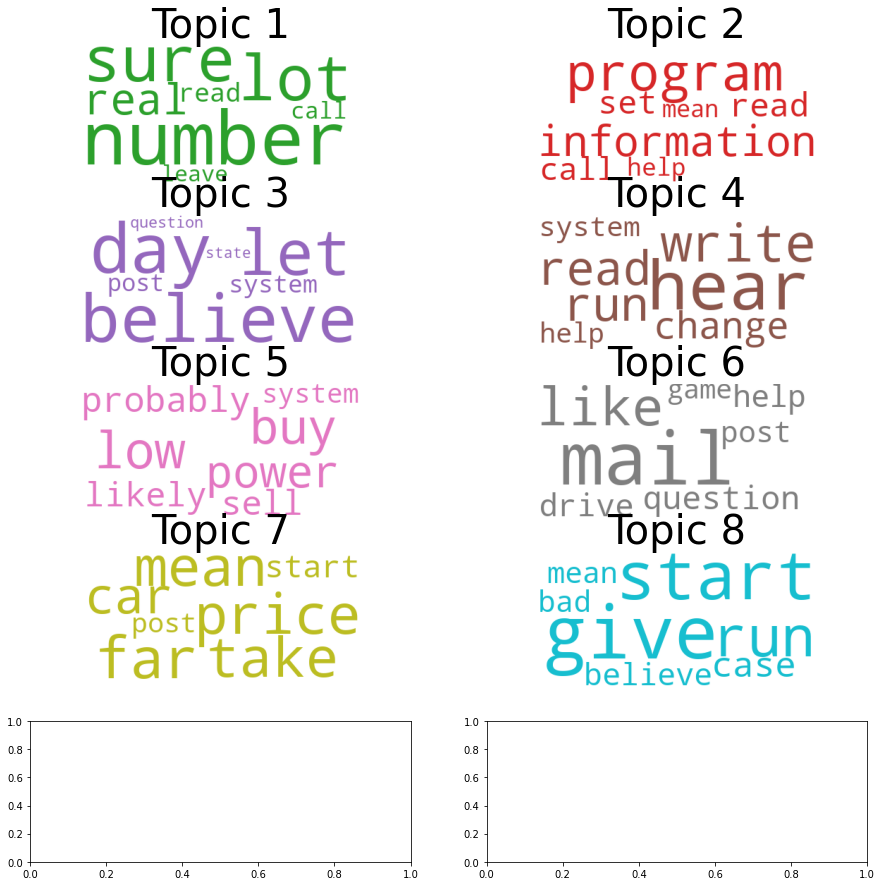

In [19]:
cols = list(mcolors.TABLEAU_COLORS.values())

# Wordcloud of Top N words in each topic with the size of the words proportional to the weight
cloud = WordCloud(stopwords=stopwords,
                  background_color='white',
                  color_func=lambda *_, **kwargs: cols[-8+i],
                  max_words=7,
                  prefer_horizontal=True)

topics = lda_model.show_topics(formatted=False, num_topics=8)
fig, axes = plt.subplots(5, 2, figsize=(15,15))

for i, ax in enumerate(axes.flatten()):
    fig.add_subplot(ax)
    topic_words = dict(topics[i][1])
    cloud.generate_from_frequencies(topic_words)
    plt.gca().imshow(cloud)
    plt.gca().axis('off')
    plt.gca().set_title(f'Topic {i+1}', font=dict(size=40))

plt.tight_layout()
plt.show()